## Dipole Current Distribution using Method of Moments
As described in Antenna Theory and Design by Constantine Balanis

#### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Specify Geometry

In [3]:
N = 201 # Number of Segments
l = 0.47*5 # Length in wavelengths
a = 0.001 # Radius in wavelengths 
fp = 0.5 # Feed position as fraction of total length

#### Current Distribution Calculation

Pocklington’s integral equation

In [4]:
def pock_eqn(zm, zn, a):
    k = 2*np.pi
    R = np.sqrt(a**2+(zm-zn)**2)
    return np.exp(-1j*k*R)/(4*np.pi*R**5)*((1+1j*k*R)*(2*R**2-3*a**2)+(k*a*R)**2)

Solve for Current Distribution using Method of Moments

In [5]:
delta = l/N # Segment length
s = 10000 # Integration points
E = np.zeros((N,1), dtype=complex)
Z = np.zeros((N,N), dtype=complex)

# Delta Gap Source Initialisation
E[int(np.floor(N*fp))] = -1j*2*np.pi/(120*np.pi*delta);

# Impedance Matrix Population
for m in tqdm(range (N)):
    zm = -l/2+(m+0.5)*delta
    for n in range (N):
        zn = -l/2+(n+0.5)*delta
        Z[m,n] = np.sum(pock_eqn(zm, np.linspace(zn-0.5*delta, zn+0.5*delta, s), a))*delta/s

# Solve
I = np.linalg.solve(Z,E)

100%|██████████| 201/201 [00:40<00:00,  4.93it/s]


Current Distribution Plot

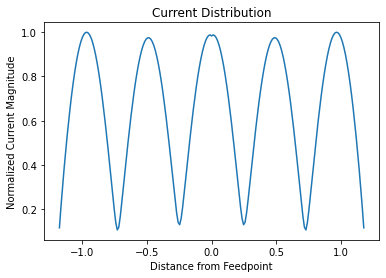

In [6]:
plt.figure();
plt.plot(np.linspace(0,l,N) - l/2, np.abs(I / np.max(np.abs(I))));
plt.title("Current Distribution");
plt.xlabel("Distance from Feedpoint");
plt.ylabel("Normalized Current Magnitude");

#### Radiation Pattern Calculation

Infinitesimal Dipole Far-Field E

In [7]:
def inf_dipole_E(theta, r, I):
    k = 2*np.pi
    return I*np.sin(theta)/r*np.exp(1j*k*r)

Sum up contributions from each segment treated as an infinitesimal dipole

In [8]:
res = 1000
r = 10000
E_theta = np.zeros(res, dtype=complex)
for s in tqdm(range(res)):
    theta = s/res*np.pi*2
    (z,x) = (r*np.cos(theta),r*np.sin(theta))
    for m in range(N):
        zm = -l/2+(m+0.5)*delta
        r_m = np.sqrt(x**2+(z-zm)**2)
        E_theta[s] += inf_dipole_E(theta, r_m, I[m])

100%|██████████| 1000/1000 [00:02<00:00, 438.23it/s]


Plot Result

C:\Users\Jordan\AppData\Local\Temp\ipykernel_2356\385457298.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.polar(np.linspace(0,2*np.pi,res), 20*np.log10(normalised_E));


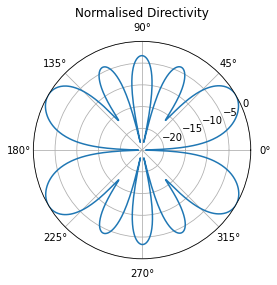

In [9]:
plt.figure();
normalised_E = np.abs(E_theta)/np.max(np.abs(E_theta))
plt.polar(np.linspace(0,2*np.pi,res), 20*np.log10(normalised_E));
plt.ylim([-25,0])
plt.title("Normalised Directivity");

Impedance Calculation

In [10]:
1/I[int(np.floor(N/2))]

array([95.39303294+26.01631784j])